## Setup environment

In [1]:
import matplotlib.pyplot as plt

from simulators.grid_world.grid_world import Maze, simulate_policy, set_granular_reward, set_normilized_reward, divide_reward_by
from simulators.grid_world import HORIZON

grid_type = "simple"
feature_type = "one_hot"
dimensions = 124

# feature_type = "simularity"
# dimensions = 100
sigma = 0.25

env = Maze(grid_type, feature_type, dimensions=dimensions, sigma=sigma)

## Expert policy

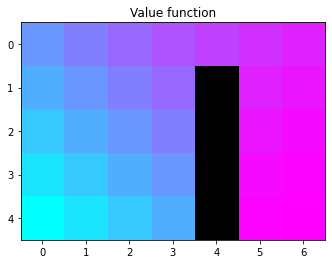

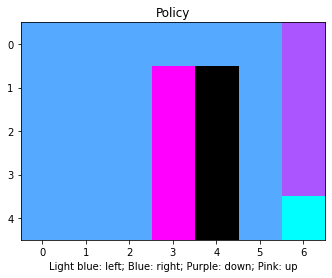

In [4]:
from algorithms.VI_dynamic_programming import value_iteration

expert_Q, expert_policy = value_iteration(env.P, env.R, env.gamma)

# Uncomment if you want to simulate the policy
# simulate_policy(expert_policy, f"../../videos/grid_world/{grid_type}_expert.mp4", env, HORIZON)

env.display_value_function(expert_Q)
env.display_policy(expert_Q)

### Change reward to granular setting

In [3]:
env = set_granular_reward(env, expert_policy)
env = set_normilized_reward(env)
env = divide_reward_by(env, 10)

## NAC

In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical


class SmallNAC(nn.Module):
    def __init__(self, env, entropy_weight):
        super(SmallNAC, self).__init__()
        self.env = env
        self.entropy_weight = entropy_weight

        self.net = nn.Sequential(
            nn.Linear(124, 1),  nn.Sigmoid()
        )
        
        self.net[0].weight.data = 0 * torch.ones(self.net[0].weight.data.size())
        self.net[0].bias.data = -3.4 * torch.ones(self.net[0].bias.data.size())

    def Q(self, state, action):
        return 3 * self.net(torch.tensor(self.env.get_feature(state, action), dtype=torch.float32))

    def V(self, state):
        v_value = 0

        for action in self.env._actions:
            v_value += torch.exp(self.Q(state, action) / self.entropy_weight)

        return self.entropy_weight * torch.log(v_value)

    def policy(self, state):
        return self.pi_distribution(state).sample()

    def pi_distribution(self, state):
        pi_actions = torch.zeros((self.env.Na))

        for action in self.env._actions:
            pi_actions[action] = torch.exp((self.Q(state, action) - self.V(state)) / self.entropy_weight)

        return Categorical(probs=pi_actions)

    def copy_to(self, target_model):
        target_model.load_state_dict(self.state_dict())

In [12]:
def get_losses(batch, model, target_model):
    actor_loss = 0
    critic_loss = 0

    for (state, action, reward, next_state) in batch:
        # Actor's loss
        q_require_grad = model.Q(state, action)
        v_require_grad = model.V(state)

        with torch.no_grad():
            v_target = target_model.V(next_state)
            entropy = model.pi_distribution(state).entropy()
        
        actor_loss += (q_require_grad - v_require_grad) * (q_require_grad.detach() - (reward + model.env.gamma * v_target))

        # Critic loss
        critic_loss += v_require_grad * (v_require_grad.detach() - (reward + model.env.gamma * v_target + model.entropy_weight * entropy))

    return actor_loss, critic_loss

In [13]:
class ReplayBuffer:
    def __init__(self, env, n_expert_samples, expert_policy, batch_size):
        self.env = env

        self.buffer_expert = []
        self.buffer_rl = []

        if n_expert_samples > 0:  # i.e with Demonstration
            self.collect_expert_samples(n_expert_samples, expert_policy)

        self.batch_size = batch_size
        self.rl_state = self.env.initial_state_distribution
        self.terminal = False

    def collect_expert_samples(self, n_samples, policy):
        for idx_sample in range(n_samples):
            state = np.random.choice(self.env._states) if idx_sample != 0 else self.env.initial_state_distribution
            self.env.state = state
            
            action = policy[state]

            next_state, reward, _, _ = self.env.step(action)

            self.buffer_expert.append((state, action, reward, next_state))

    def collect_rl_sample(self, model):
        if self.terminal:
            self.rl_state = self.env.initial_state_distribution
        self.env.state = self.rl_state

        action = model.policy(self.env.state).detach().numpy()

        next_state, reward, self.terminal, _ = self.env.step(action)

        self.buffer_rl.append((self.rl_state, action, reward, next_state))
        self.rl_state = next_state
    
    def get_batch(self, from_expert=True):
        if from_expert:
            return [self.buffer_expert[np.random.choice(range(len(self.buffer_expert)))] for _ in range(self.batch_size)]
        else:
            return [self.buffer_rl[np.random.choice(range(len(self.buffer_rl)))] for _ in range(self.batch_size)]

    def display_statistics(self, from_expert):
        number_occurences = np.zeros(self.env.S)

        if from_expert:
            for (state, _, _, _) in self.buffer_expert:
                number_occurences[state] += 1
        else:
            for (state, _, _, _) in self.buffer_rl:
                number_occurences[state] += 1       

        img = self.env.get_layout_img(number_occurences)
        plt.figure()
        plt.title("Statistics on occurences")
        plt.imshow(img)
        plt.show()

In [14]:
import numpy as np


def nac(env, entropy_weight, n_expert_samples, n_expert_iterations, n_rl_iterations, batch_size, update_target_frequency, show_policy=False, show_value_function=False, show_statistics=False, display_frequency=1):
    # from algorithms.NAC.replay_buffer import ReplayBuffer
    # from algorithms.NAC.model import SmallNAC

    if n_expert_samples > 0:
        from algorithms.VI_dynamic_programming import value_iteration

        _, expert_policy = value_iteration(env.P, env.R, env.gamma)
    else:
        expert_policy = None
    
    replay_buffer = ReplayBuffer(
        env,
        n_expert_samples,
        expert_policy,
        batch_size,
    )
    model = SmallNAC(env, entropy_weight)
    target_model = SmallNAC(env, entropy_weight)
    model.copy_to(target_model)

    optimizer = torch.optim.SGD(model.parameters(), lr=1)

    for iteration in range(n_expert_iterations + n_rl_iterations):
        from_expert = True if iteration < n_expert_iterations else False

        if iteration == n_expert_iterations:
            optimizer.param_groups[0]['lr'] = 1e-2

        if not from_expert:
            replay_buffer.collect_rl_sample(model)

        batch = replay_buffer.get_batch(from_expert=from_expert)

        if show_statistics and iteration % display_frequency == 0:
            replay_buffer.display_statistics(from_expert)

        actor_loss, critic_loss = get_losses(batch, model, target_model)
        loss = actor_loss + critic_loss

        # ##
        # state, action, reward, next_state = batch
        # print("Q before", model.Q(state, action).detach().numpy()[0])
        # print("V before", model.V(state).detach().numpy()[0])
        # print("Coeff", model.Q(state, action) - (reward + env.gamma * model.V(next_state)))
        # ##

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ##
        # print("Q after", model.Q(state, action).detach().numpy()[0])
        # print("V after", model.V(state).detach().numpy()[0])
        # print("Proba", np.argmax(model.pi_distribution(state).probs.detach().numpy()))
        # print("Max proba", model.pi_distribution(state).probs.detach().numpy())
        # print()
        # ##
        
        if show_value_function and iteration % display_frequency == 0:
            value_function = np.zeros((env.Ns))

            for state in env._states:
                value_function[state] = model.V(state)
            env.display_value_function(value_function, from_value=True)
        if (show_policy and iteration % display_frequency == 0) or iteration == n_expert_iterations:
            if iteration == n_expert_iterations:
                print("End expert iterations")
            policy = np.zeros((env.Ns))

            for state in env._states:
                policy[state] = np.argmax(model.pi_distribution(state).probs.detach().numpy())
            env.display_policy(policy, from_pi=True)

        if iteration % update_target_frequency == 0:
            model.copy_to(target_model)

    return model

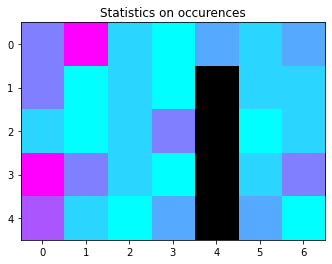

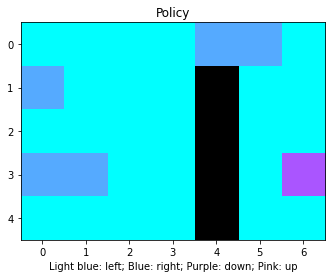

End expert iterations


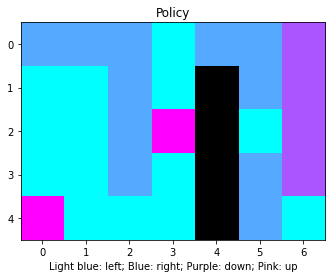

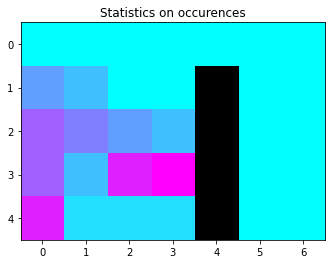

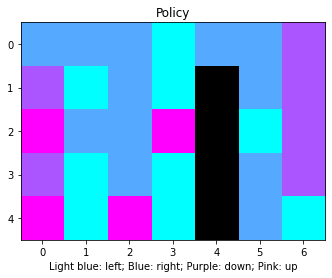

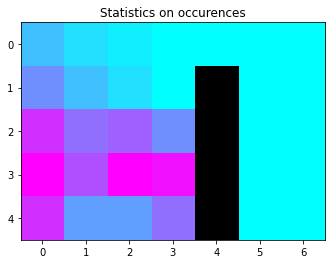

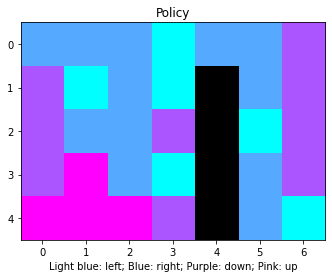

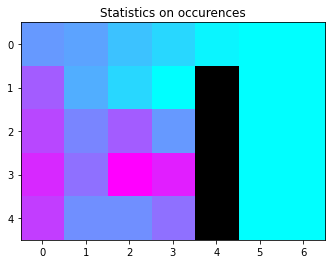

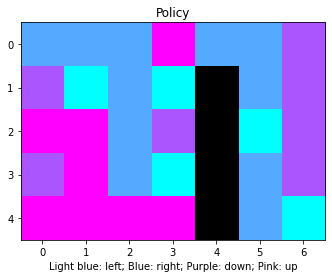

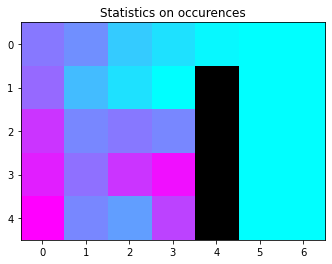

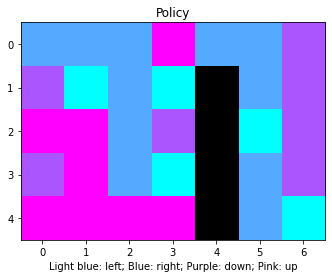

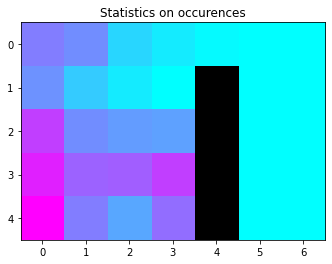

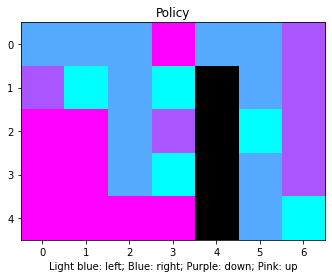

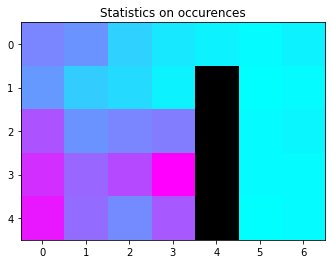

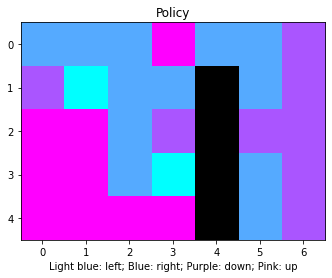

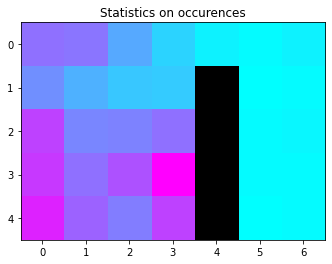

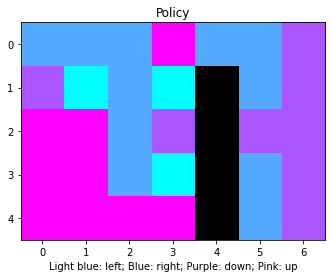

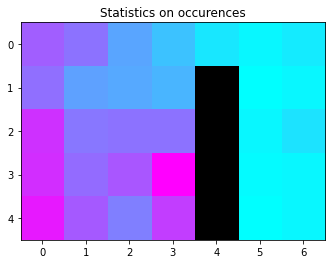

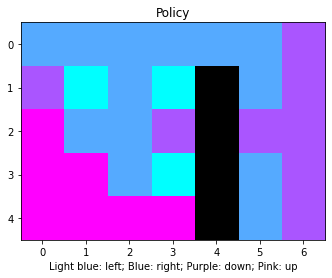

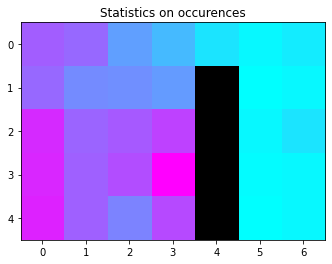

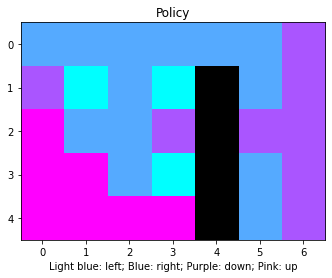

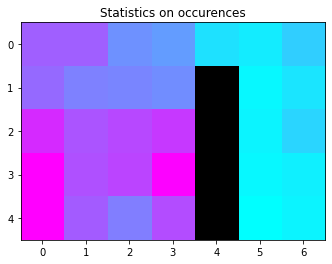

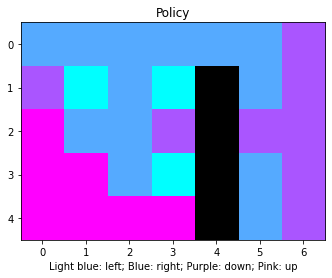

In [35]:
# from algorithms.NAC.nac import nac

entropy_weight = 0.1
n_expert_samples = 50
n_expert_iterations = 50
n_rl_iterations = 1000
batch_size = 10
update_target_frequency = 20
show_args = {"show_policy":True, "show_value_function": False, "show_statistics": True, "display_frequency": 100}

nac_Q = nac(
    env,
    entropy_weight, 
    n_expert_samples, 
    n_expert_iterations, 
    n_rl_iterations, 
    batch_size,
    update_target_frequency,
    **show_args,
)